In [1]:
%cd ~/p/npworks/20200222-Vero-SCV2/basemod/flg-stats

/blaze/hyeshik/p/npworks/20200222-Vero-SCV2/basemod/flg-stats


In [2]:
annotations = pd.read_csv('../../refs/SARS-CoV-2-annotations.gff', sep='\t',
                         names=['chrom', 'type', 'name', 'start', 'end', '_x', '_y', '_z'])
annotations['start'] -= 1
cdsanno = annotations.iloc[:10]
cdsanno = pd.concat([
    cdsanno,
    pd.DataFrame([pd.Series(['chrSCV', 'CDS', 'ORF1ab', 265, 21555, 0.0, '.', '.'],
              index=cdsanno.columns)])
]).sort_values(by='start').reset_index(drop=True).iloc[:10, :5]

In [3]:
ORFs = cdsanno['name'].tolist()
import h5py

In [4]:
def load_stats(orf):
    with h5py.File(orf + '.5mC.tombo.stats', 'r') as f5:
        mgstats = []

        for block in f5['Statistic_Blocks'].values():
            blkstats = pd.DataFrame(block['block_stats'][()])
            print(blkstats['pos'].describe())
            mgstats.append(blkstats)
            
        return pd.concat(mgstats).sort_values(by='pos', ascending=True).reset_index(drop=True)
ivt5mC = load_stats('IVT1-denovo')

count       50.000000
mean     13536.820000
std       1768.724707
min      11041.000000
25%      11128.000000
50%      14717.500000
75%      14847.750000
max      14916.000000
Name: pos, dtype: float64
count     209.000000
mean     5427.497608
std       701.098102
min      4351.000000
25%      4719.000000
50%      5452.000000
75%      6001.000000
max      6661.000000
Name: pos, dtype: float64
count     1809.000000
mean     14996.244334
std       2874.936994
min      10001.000000
25%      12527.000000
50%      15036.000000
75%      17484.000000
max      19982.000000
Name: pos, dtype: float64
count     1892.000000
mean     25244.196089
std       2803.827528
min      20007.000000
25%      22948.750000
50%      25374.500000
75%      27692.500000
max      29869.000000
Name: pos, dtype: float64
count    1740.000000
mean     4837.289655
std      2947.352659
min        14.000000
25%      2225.750000
50%      4816.500000
75%      7376.500000
max      9995.000000
Name: pos, dtype: float64


(array([2930.,  818.,  503.,  356.,  267.,  185.,  132.,  162.,  143.,
         204.]),
 array([0.        , 0.09988479, 0.19976959, 0.29965438, 0.39953917,
        0.49942396, 0.59930876, 0.69919355, 0.79907834, 0.89896313,
        0.99884793]),
 <a list of 10 Patch objects>)

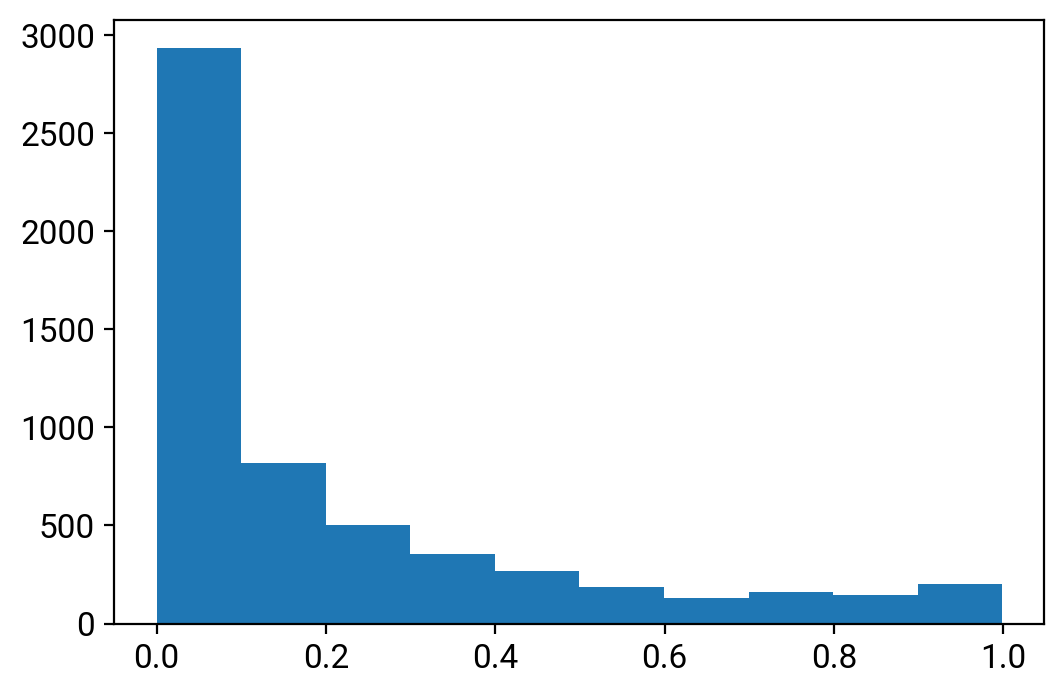

In [5]:
plt.hist(1 - ivt5mC['damp_frac'])

In [6]:
ivt5mC

,damp_frac,frac,pos,cov,control_cov,valid_cov
0,0.700183,0.699817,14,5560,0,1639
1,0.447154,0.446555,15,6264,0,1843
2,0.070922,0.057554,18,7629,0,139
3,0.072727,0.061350,19,7786,0,163
4,0.014448,0.012410,20,7919,0,967
...,...,...,...,...,...,...
5695,0.981452,0.981444,29835,8679,0,4419
5696,0.996963,0.996962,29836,8678,0,5267
5697,0.996587,0.996586,29837,8672,0,5858
5698,0.022700,0.020359,29853,8549,0,835


In [7]:
ivt5mC_hi = ivt5mC[(ivt5mC['damp_frac'] > 0.1) & (ivt5mC['valid_cov'] >= 500)]
ivt5mC_truecall = ivt5mC[(ivt5mC['damp_frac'] <= 0.1) & (ivt5mC['valid_cov'] >= 500)]

In [8]:
len(ivt5mC_hi), len(ivt5mC_truecall)

(4853, 167)

In [9]:
ivtcov = \
pd.read_csv('../../stats/IVT1.balanced.coverage.txt', sep='\t',
           names=['chrom', 'pos', 'coverage'])

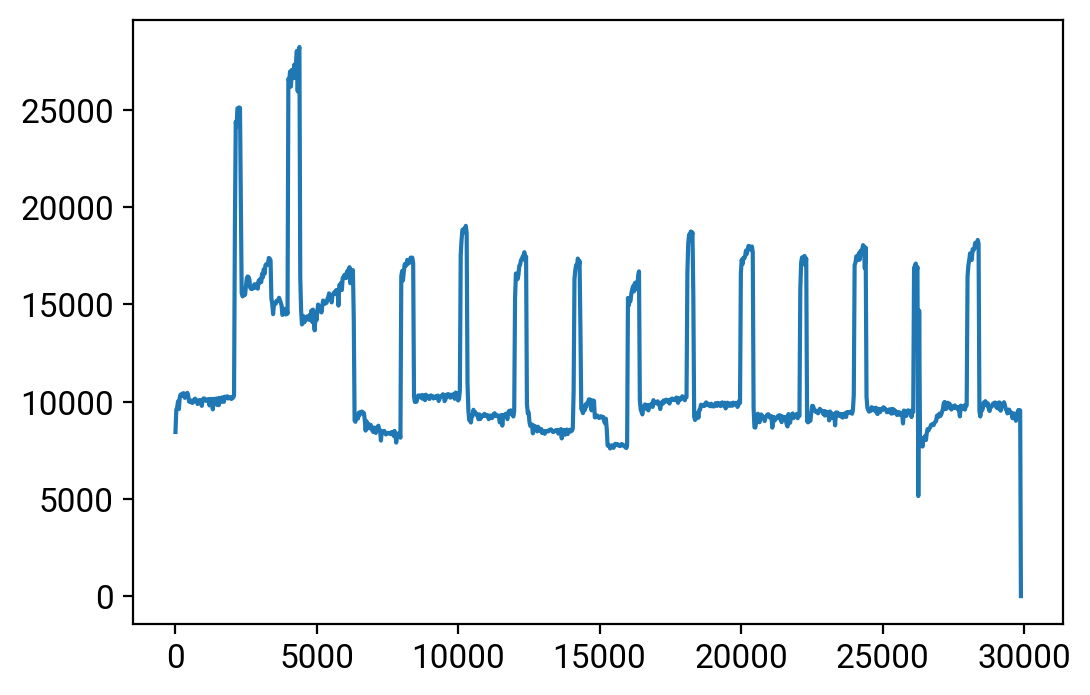

In [10]:
ivtcov['posbin'] = ivtcov['pos'] // 30 * 30
ivtcovsimple = ivtcov.groupby('posbin').agg({'pos': 'mean', 'coverage': 'median'})
plt.plot(ivtcovsimple['pos'], ivtcovsimple['coverage'])

In [11]:
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches

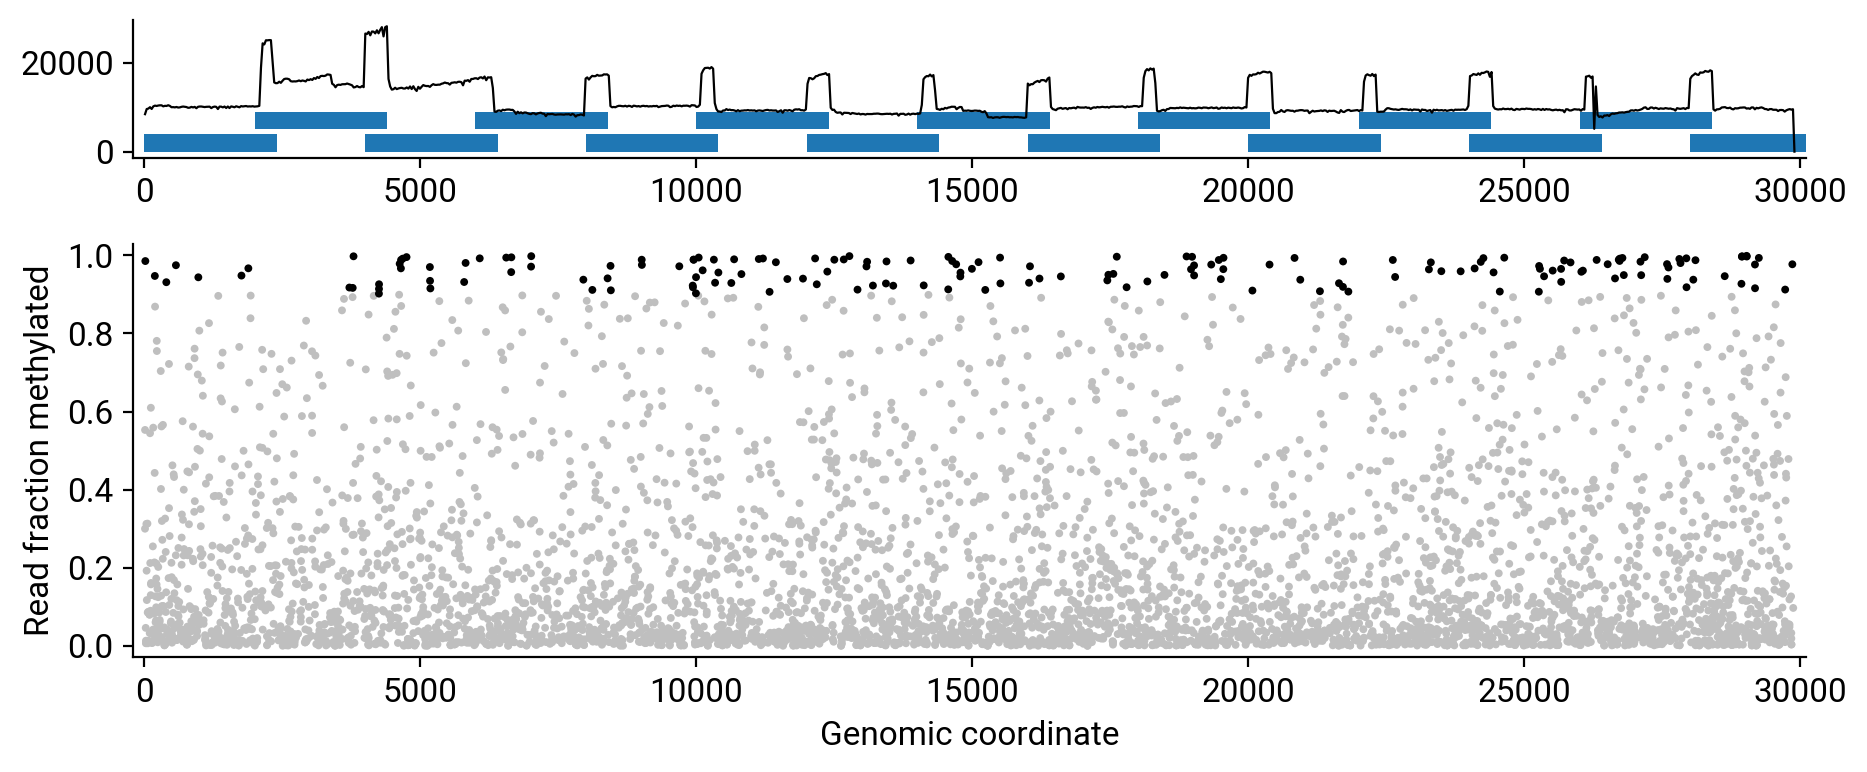

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(9.5, 4),
                         gridspec_kw={'height_ratios': [1, 3]})

ax = axes[0]

ax.plot(ivtcovsimple['pos'], ivtcovsimple['coverage'], lw=0.8, c='black')
for spname in 'top right'.split():
    plt.setp(ax.spines[spname], visible=False)

for i in range(15):
    ax.add_patch(patches.Rectangle((i * 2000, 0 if i % 2 == 0 else 5000), 2400, 4000))

ax.set_xlim(-200, 30100)

ax = axes[1]

ax.scatter(ivt5mC_hi['pos'], 1-ivt5mC_hi['damp_frac'], c='#bfbfbf', s=8, edgecolor='none', zorder=1)
ax.scatter(ivt5mC_truecall['pos'], 1-ivt5mC_truecall['damp_frac'], c='#000000', s=8, edgecolor='none', zorder=2)

for spname in 'top right'.split():
    plt.setp(ax.spines[spname], visible=False)

ax.set_ylim(-0.03, 1.03)
ax.set_xlim(-200, 30100)
ax.set_ylabel('Read fraction methylated')
ax.set_xlabel('Genomic coordinate')

plt.tight_layout()
plt.savefig('../../figure-outputs/tombo-hypermethylation.pdf')

## Methylation calls for IVT products

In [17]:
def load_stats(orf):
    with h5py.File(orf + '.5mC.tombo.stats', 'r') as f5:
        mgstats = []

        for block in f5['Statistic_Blocks'].values():
            blkstats = pd.DataFrame(block['block_stats'][()])
            mgstats.append(blkstats)
            
        return pd.concat(mgstats).sort_values(by='pos', ascending=True).reset_index(drop=True)

viral5mC = load_stats('full-alternate-model')

In [18]:
viral5mC

,damp_frac,frac,pos,cov,control_cov,valid_cov
0,0.500000,0.000000,7,4,0,2
1,0.434783,0.380952,14,58,0,21
2,0.659378,0.658804,15,4156,0,1187
3,0.241758,0.224719,18,6595,0,89
4,0.151316,0.140000,19,6759,0,150
...,...,...,...,...,...,...
8139,0.998479,0.998479,29836,178393,0,109819
8140,0.998551,0.998551,29837,178381,0,126980
8141,0.666667,0.000000,29852,2,0,1
8142,0.024914,0.024824,29853,177693,0,21552


In [21]:
viral5mC_hi = viral5mC[(viral5mC['damp_frac'] > 0.1) & (viral5mC['valid_cov'] >= 100)]
viral5mC_truecall = viral5mC[(viral5mC['damp_frac'] <= 0.1) & (viral5mC['valid_cov'] >= 100)]

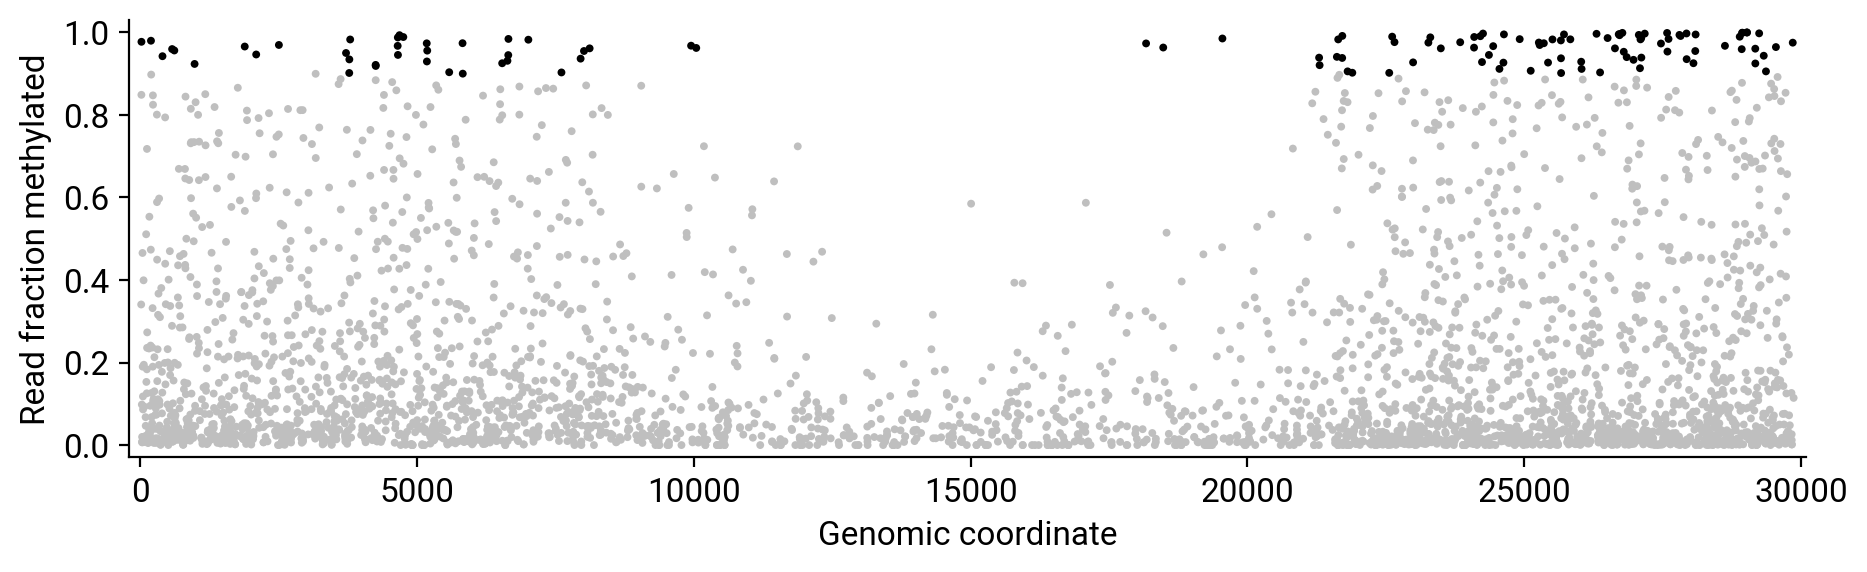

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(9.5, 3))

ax.scatter(viral5mC_hi['pos'], 1-viral5mC_hi['damp_frac'], c='#bfbfbf', s=8, edgecolor='none', zorder=1)
ax.scatter(viral5mC_truecall['pos'], 1-viral5mC_truecall['damp_frac'], c='#000000', s=8, edgecolor='none', zorder=2)

for spname in 'top right'.split():
    plt.setp(ax.spines[spname], visible=False)

ax.set_ylim(-0.03, 1.03)
ax.set_xlim(-200, 30100)
ax.set_ylabel('Read fraction methylated')
ax.set_xlabel('Genomic coordinate')

plt.tight_layout()

## Comparison of methylation calls by alternative model

In [44]:
mcmerge = pd.merge(viral5mC, ivt5mC, left_on='pos', right_on='pos', suffixes=['_vir', '_ivt'])
mcmerge['5mC_vir'] = 1 - mcmerge['damp_frac_vir']
mcmerge['5mC_ivt'] = 1 - mcmerge['damp_frac_ivt']
mcmerge['5mC_logodds'] = np.log2(mcmerge['5mC_vir'] / mcmerge['5mC_ivt'])
mcmerge = mcmerge[(mcmerge['valid_cov_vir'] >= 100) & (mcmerge['valid_cov_ivt'] >= 100)]

/blaze/hyeshik/conda/envs/lab/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


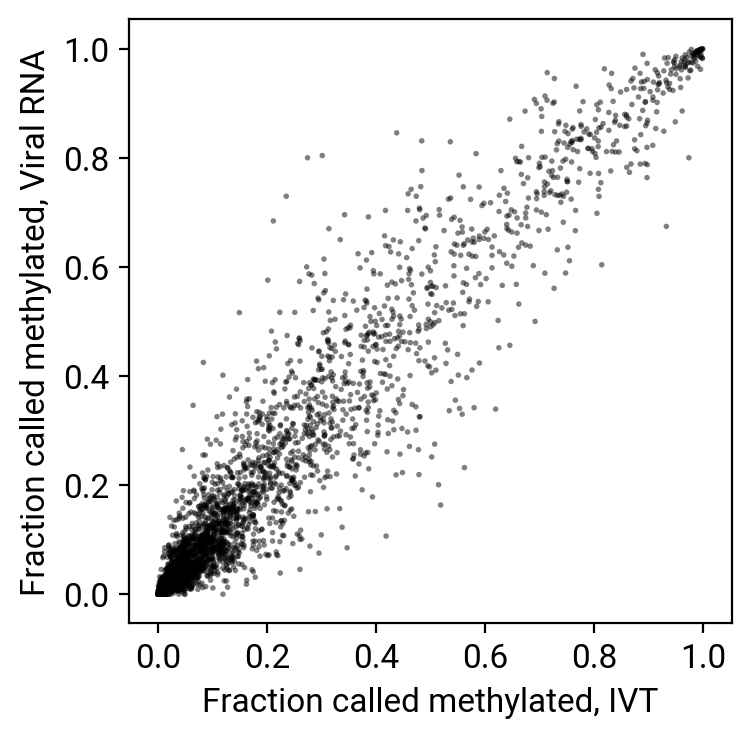

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(mcmerge['5mC_ivt'], mcmerge['5mC_vir'], c='black', s=4, edgecolor='none', alpha=.5)
ax.set_aspect(1)
ax.set_xlabel('Fraction called methylated, IVT')
ax.set_ylabel('Fraction called methylated, Viral RNA')
plt.savefig('../../figure-outputs/Tombo-hypermethylation-another.pdf')